## Goal

Using a dataset from Jason Brownlee, author of the amazing MachineLearningMastery.com site and who has shared lots of datasets at https://github.com/jbrownlee/Datasets. It’s a dataset of daily minimum temperatures in the city of Melbourne, Australia measured from 1981 to 1990.

Goal is to download the dataset, parse the CSV, create a time series and build a prediction model from it. The model should have an MAE of less than 2.

## Importing Libraries

In [1]:
import os
import csv
import wget

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

## Loading Dataset

In [2]:
path = os.getcwd()+"\..\data\\daily-min-temperatures.csv"
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
wget.download(url, out = path)

100% [..............................................................................] 67921 / 67921

'C:\\Users\\Parivi\\Desktop\\Archisha\\Coursera\\CV-Datasets-using-TensorFlow\\Time Series Prediction\\..\\data\\daily-min-temperatures.csv'

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

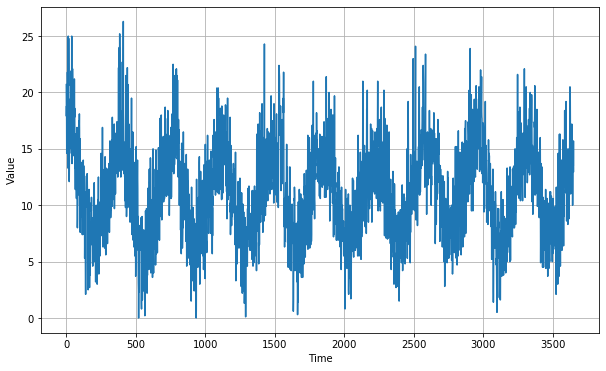

In [5]:
time_step = []
temps = []

with open('../data/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

## Defining Constants for Splitting and Windowing

In [6]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

## Building a Model

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 3s 336ms/step - loss: 31.1571 - mae: 31.6550 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 3s 309ms/step - loss: 30.5778 - mae: 31.0756 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 3s 276ms/step - loss: 29.6825 - mae: 30.1801 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 3s 266ms/step - loss: 28.5613 - mae: 29.0586 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 3s 269ms/step - loss: 27.1974 - mae: 27.6945 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 3s 256ms/step - loss: 25.5017 - mae: 25.9986 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 3s 271ms/step - loss: 23.3464 - mae: 23.8429 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 3s 309ms/step - loss: 20.6148 - mae: 21.

10/10 [==============================] - 3s 268ms/step - loss: 5.1840 - mae: 5.6716 - lr: 3.1623e-05
Epoch 72/100
10/10 [==============================] - 3s 268ms/step - loss: 6.9092 - mae: 7.3959 - lr: 3.5481e-05
Epoch 73/100
10/10 [==============================] - 3s 307ms/step - loss: 17.0514 - mae: 17.5484 - lr: 3.9811e-05
Epoch 74/100
10/10 [==============================] - 3s 305ms/step - loss: 3.7247 - mae: 4.2021 - lr: 4.4668e-05
Epoch 75/100
10/10 [==============================] - 3s 286ms/step - loss: 2.8516 - mae: 3.3189 - lr: 5.0119e-05
Epoch 76/100
10/10 [==============================] - 3s 313ms/step - loss: 2.1828 - mae: 2.6402 - lr: 5.6234e-05
Epoch 77/100
10/10 [==============================] - 3s 269ms/step - loss: 2.1099 - mae: 2.5663 - lr: 6.3096e-05
Epoch 78/100
10/10 [==============================] - 3s 277ms/step - loss: 2.3226 - mae: 2.7835 - lr: 7.0795e-05
Epoch 79/100
10/10 [==============================] - 3s 273ms/step - loss: 2.6821 - mae: 3.1508 - 

Learning rate v. Loss

[1e-08, 0.0001, 0, 60]

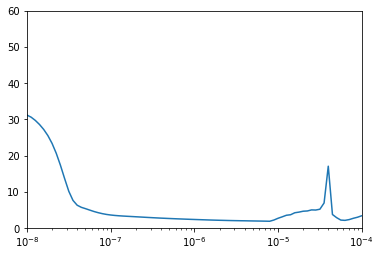

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Using the modified Learning Rate

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 4s 161ms/step - loss: 9.9820 - mae: 10.4701
Epoch 2/150
25/25 [==============================] - 4s 165ms/step - loss: 2.5293 - mae: 2.9921
Epoch 3/150
25/25 [==============================] - 4s 157ms/step - loss: 1.9501 - mae: 2.4046 2s - loss: 
Epoch 4/150
25/25 [==============================] - 4s 154ms/step - loss: 1.8619 - mae: 2.3151 2s - loss
Epoch 5/150
25/25 [==============================] - 4s 172ms/step - loss: 1.8215 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 4s 175ms/step - loss: 1.7909 - mae: 2.2418 1s - loss: 1.8205 - 
Epoch 7/150
25/25 [==============================] - 4s 167ms/step - loss: 1.7686 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 6s 237ms/step - loss: 1.7413 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 5s 182ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 5s 192ms/step - loss: 1.7000 - mae: 2.

25/25 [==============================] - 4s 167ms/step - loss: 1.5080 - mae: 1.9494 1s - loss: 1.5360 -
Epoch 84/150
25/25 [==============================] - 4s 150ms/step - loss: 1.5084 - mae: 1.9501
Epoch 85/150
25/25 [==============================] - 4s 145ms/step - loss: 1.5069 - mae: 1.9484
Epoch 86/150
25/25 [==============================] - 4s 144ms/step - loss: 1.5061 - mae: 1.9475
Epoch 87/150
25/25 [==============================] - 3s 134ms/step - loss: 1.5074 - mae: 1.9489
Epoch 88/150
25/25 [==============================] - 4s 146ms/step - loss: 1.5053 - mae: 1.9467
Epoch 89/150
25/25 [==============================] - 4s 178ms/step - loss: 1.5050 - mae: 1.9463
Epoch 90/150
25/25 [==============================] - 4s 165ms/step - loss: 1.5064 - mae: 1.9479
Epoch 91/150
25/25 [==============================] - 4s 166ms/step - loss: 1.5055 - mae: 1.9468
Epoch 92/150
25/25 [==============================] - 4s 162ms/step - loss: 1.5045 - mae: 1.9459
Epoch 93/150
25/25 [===

## Forecasting

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

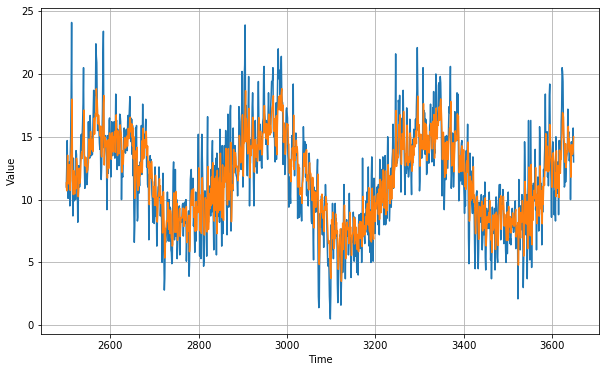

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

## Loss

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7796184